In [1]:
import os
import glob
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def process_images(directory, limit=600):

    normal_image_list = []
    pneu_image_list = []

    # Loop through each subdirectory in the specified folder
    for dir_name in os.listdir(directory):
        dir_path = os.path.join(directory, dir_name)

        # Counter for the number of processed images
        count = 0

        # Loop through each image file in the directory to load
        for image_path in glob.glob(os.path.join(dir_path, '*.jpeg')):
            if count >= limit:
                break

            image = Image.open(image_path).convert('RGB')

            # Resize the image
            image_resized = image.resize((224, 224))

            # Convert the image to a numpy array and normalize pixels
            image_array = np.array(image_resized)
            image_normalized = image_array / 255.0

            # Append the processed image to the appropriate list
            if dir_name == 'NORMAL':
                normal_image_list.append(image_normalized)
            elif dir_name == 'PNEUMONIA':
                pneu_image_list.append(image_normalized)

            count += 1

    return normal_image_list, pneu_image_list

In [4]:
# processing training data
train_dir = '/content/drive/MyDrive/CNN_model/train'
normal_images_list, pneu_images_list = process_images(train_dir, limit=600)


In [5]:
# Convert the list of images to a numpy array
normal_images = np.array(normal_images_list)
pneu_images = np.array(pneu_images_list)

print(normal_images.shape)
print(pneu_images.shape)


(600, 224, 224, 3)
(600, 224, 224, 3)


In [6]:
# Create labels (0 for normal, 1 for pneumonia)
normal_labels = np.zeros(len(normal_images))
pneu_labels = np.ones(len(pneu_images))

# Combine images and labels
X_train = np.concatenate([normal_images, pneu_images], axis=0)
y_train= np.concatenate([normal_labels, pneu_labels], axis=0)



In [7]:
# process testing data
test_dir = '/content/drive/MyDrive/CNN_model/test'
normal_test_list, pneu_test_list = process_images(test_dir, limit = 200)


In [8]:
# Convert the list of images to a numpy array
normal_test_images = np.array(normal_test_list)
pneu_test_images = np.array(pneu_test_list)

print(normal_test_images.shape)
print(pneu_test_images.shape)

(200, 224, 224, 3)
(200, 224, 224, 3)


In [9]:
# Create labels (0 for normal, 1 for pneumonia)
normal_test_labels = np.zeros(len(normal_test_images))
pneu_test_labels = np.ones(len(pneu_test_images))

# Combine images and labels
X_test = np.concatenate([normal_test_images, pneu_test_images], axis=0)
y_test = np.concatenate([normal_test_labels, pneu_test_labels], axis=0)


In [10]:
#build a CNN model
model = Sequential([
    Input(shape=(224, 224, 3)),  # Define the input shape
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.02)),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.02)),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.02)),
    MaxPooling2D((2, 2)),
    Dropout(0.4),
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.02)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       5,537,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,631,169 (21.48 MB)

 Trainable params: 5,631,169 (21.48 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Add early stoppin and reduce learning rate to prevent over fitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)


In [12]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Fit the model
history = model.fit(X_train, y_train,
                    epochs=20,
                    validation_data = (X_test, y_test),
                    callbacks=[early_stopping, reduce_lr])



Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 101s 3s/step - accuracy: 0.4973 - loss: 4.7239 - val_accuracy: 0.5000 - val_loss: 2.0565 - learning_rate: 0.0010
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.5237 - loss: 1.7933 - val_accuracy: 0.8350 - val_loss: 1.2557 - learning_rate: 0.0010
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.6813 - loss: 1.1245 - val_accuracy: 0.8375 - val_loss: 0.8629 - learning_rate: 0.0010
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.8202 - loss: 0.7673 - val_accuracy: 0.8700 - val_loss: 0.7092 - learning_rate: 0.0010
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.8734 - loss: 0.6455 - val_accuracy: 0.8500 - val_loss: 0.6418 - learning_rate: 0.0010
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.8847 - loss: 0.5530 - val_accuracy: 0.8725 - val_loss: 0.5909 - learning_rate: 0.0010
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.8839 - loss: 0.4920 - val_accu

In [13]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')


13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 679ms/step - accuracy: 0.8959 - loss: 0.5631
Validation Loss: 0.5908557772636414
Validation Accuracy: 0.8725000023841858


In [26]:
# Export our model to HDF5 file
from google.colab import files

model.save('chest_Xray.h5')
files.download('chest_Xray.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

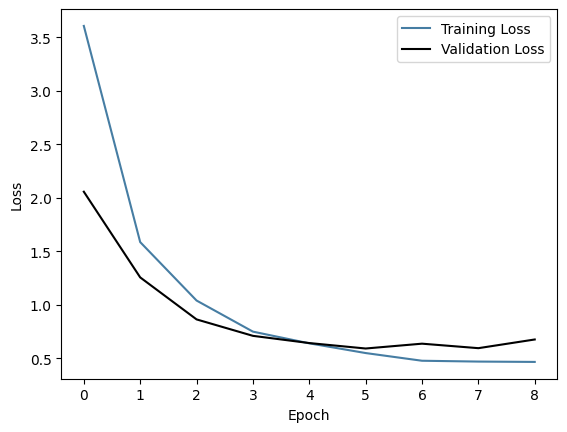

In [43]:
plt.plot(history.history['loss'], color = '#467da3', label='Training Loss')
plt.plot(history.history['val_loss'], color = 'black', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss.jpeg', dpi=1000, format='jpeg',bbox_inches='tight')
plt.show()

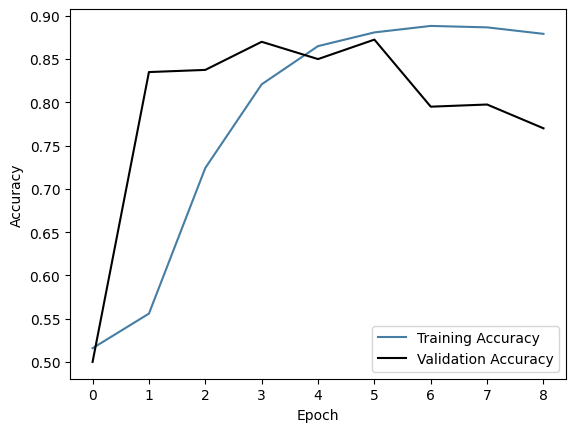

In [42]:
plt.plot(history.history['accuracy'], color = '#467da3', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], color = 'black', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy.jpeg', dpi=1000, format='jpeg',bbox_inches='tight')
plt.show()

In [17]:
# Generate a confusion matrix for the model
predictions = model.predict(X_test)
pred_labels = (predictions > 0.5).astype(int)
cm = confusion_matrix(y_test, pred_labels)



13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 647ms/step


<Figure size 800x600 with 0 Axes>

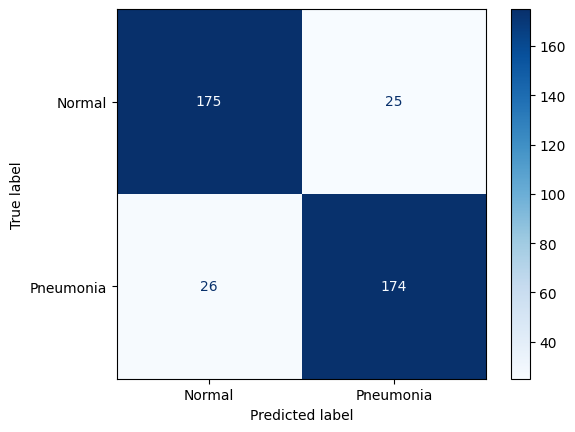

In [41]:
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Pneumonia'])

plt.figure(figsize=(8, 6))
disp.plot(cmap = 'Blues', values_format='d')
plt.savefig('confusion_matrix.jpeg', dpi=1000, format='jpeg',bbox_inches='tight')
plt.show()

In [35]:
# Print the classification report comparing the testing data to the model predictions

report = classification_report(y_test, pred_labels, output_dict = True)
report_df = pd.DataFrame(report).transpose()
report_df = report_df[['precision', 'recall']]
report_df.to_csv('class_report.csv', index = True)